In [ ]:
!pip install -U tensorflow

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import numpy as np
import time
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint


In [ ]:
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import GlobalAveragePooling2D, Dense
from keras.models import Model
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from keras.applications.mobilenet_v2 import MobileNetV2
import time
import math


In [ ]:
import os
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
import shutil

folder_path = '/content/drive/MyDrive/cars_test'
output_path = '/content/drive/MyDrive/cars_test_augmented'

# Define the data augmentation parameters
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Loop over all the files in the folder
for subdir, dirs, files in os.walk(folder_path):
    for file in files:
        file_path = os.path.join(subdir, file)
        
        # Load the image and convert it to a NumPy array
        img = load_img(file_path)
        x = img_to_array(img)
        x = x.reshape((1,) + x.shape)

        # Create the output directory if it does not exist
        relative_subdir = os.path.relpath(subdir, folder_path)
        output_subdir = os.path.join(output_path, relative_subdir)
        os.makedirs(output_subdir, exist_ok=True)

        # Copy the original image to the output directory
        shutil.copy(file_path, os.path.join(output_subdir, file))

        # Generate augmented images and save them to the output directory
        i = 0
        for batch in datagen.flow(x, batch_size=1, save_to_dir=output_subdir, save_prefix=file[:-4], save_format='jpg'):
            i += 1
            if i > 0: # Generate 1 augmented images per original image
                break


In [ ]:
img_height, img_width = 224, 224
batch_size = 32

# Added data augmentation to the training data generator
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

validation_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    '/content/drive/MyDrive/cars_test',
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical', #makes 10 ordered vectors ex bmw[1,0,0]
    shuffle=True
)

validation_generator = validation_datagen.flow_from_directory(
    '/content/drive/MyDrive/cars_train',
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

Found 3732 images belonging to 10 classes.
Found 1594 images belonging to 10 classes.


In [ ]:
from tensorflow.keras import mixed_precision
#cnn 17 blocks 2 layers/ block : depthwise & pointwise
#depth: each input has own channel, point: 1x1 filter to combine channels
# telling TensorFlow to use float16 data type for certain operations during training
policy = mixed_precision.Policy('mixed_float16') 
mixed_precision.set_global_policy(policy)

#using pretrained model base, so take off top layers 
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(img_height, img_width, 3)) #3-rgb

x = base_model.output
x = GlobalAveragePooling2D()(x) #reduces # parameters but focus on spatial relationships
x = Dense(1024, activation='relu')(x) #relu introduces nonlinearity(patterns), helps learn complexity

predictions = Dense(10, activation='softmax', dtype='float32')(x) 
#adding new layer, dense=neuron connected to neuron in prev layers
#10 outp units(10 models)
#softmax connects outputs to probability
#float32 default outp for keras

model = Model(inputs=base_model.input, outputs=predictions)

for layer in base_model.layers:
    layer.trainable = False #not training base model, only additions

model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])
#categorical_crossentropy helps measure loss aka difference between images

9406464/9406464 [==============================] - 0s 0us/step


In [ ]:
def step_decay(epoch):
    initial_lrate = 0.001
    drop = 0.5
    epochs_drop = 25.0
    lrate = initial_lrate * math.pow(drop, math.floor((1 + epoch) / epochs_drop))
    return lrate

lrate_scheduler = LearningRateScheduler(step_decay)


In [ ]:
train_steps = len(train_generator) #returns length aka steps
validation_steps = len(validation_generator)

start_time = time.time()
history = model.fit(
    train_generator,
    steps_per_epoch=train_steps,
    epochs=1,
    validation_data=validation_generator,
    validation_steps=validation_steps
)
elapsed_time = time.time() - start_time
print(f"Elapsed time for one epoch: {elapsed_time:.2f} seconds")


/usr/local/lib/python3.9/dist-packages/PIL/Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


117/117 [==============================] - 1771s 15s/step - loss: 1.3345 - accuracy: 0.5447 - val_loss: 0.9649 - val_accuracy: 0.6619
Elapsed time for one epoch: 1839.05 seconds


In [ ]:
num_epochs = 100
checkpoint_frequency = 5

checkpoint_callback = ModelCheckpoint(
    filepath='vehicle_model_classifier_epoch_{epoch:02d}.h5',
    save_freq=checkpoint_frequency * train_steps,
    save_best_only=False
)

# Added the learning rate scheduler to the callbacks list
history = model.fit(
    train_generator,
    steps_per_epoch=train_steps,
    epochs=num_epochs,
    validation_data=validation_generator,
    validation_steps=validation_steps,
    callbacks=[checkpoint_callback, lrate_scheduler]
)

In [ ]:
epochs = range(1, num_epochs + 1, checkpoint_frequency)
validation_accuracy = history.history['val_accuracy'][::checkpoint_frequency]

plt.plot(epochs, validation_accuracy)
plt.xlabel('Epochs')
plt.ylabel('Validation Accuracy')
plt.title('Validation Accuracy for Checkpoints')
plt.xticks(epochs)
plt.grid(True)
plt.show()

In [ ]:
best_epoch = (np.argmax(validation_accuracy) * checkpoint_frequency) + 1
print(f"The best checkpoint is from epoch {best_epoch}")


In [ ]:
####################################
import os
from PIL import Image

def find_corrupted_images(folder_path):
    for root, dirs, files in os.walk(folder_path):
        for file in files:
            if file.lower().endswith(('.png', '.jpg', '.jpeg', '.JPG', '.PNG', '.JPEG')):
                file_path = os.path.join(root, file)
                try:
                    with Image.open(file_path) as img:
                        img.verify()
                except Exception as e:
                    print(f"Corrupted image: {file_path}")
                    print(f"Error: {e}")

find_corrupted_images('/content/drive/MyDrive/cars_test')
#find_corrupted_images('/content/drive/MyDrive/cars_train')


In [ ]:
################################
import os
from PIL import Image

folder_path = '/content/drive/MyDrive/cars_test'

for subdir, dirs, files in os.walk(folder_path):
    for file in files:
        file_path = os.path.join(subdir, file)
        try:
            with Image.open(file_path) as img:
                # check if image is truncated
                img.load()
        except Exception as e:
            print(f"Truncated image detected: {file_path}")
            # delete the truncated image
            os.remove(file_path)


In [ ]:
#########################################
import os
import shutil
from PIL import Image

def remove_whitespace(image_path):
    image = Image.open(image_path)
    if "transparency" in image.info:
        image = image.convert("RGBA")
    
    # Save the modified image back to the same path
    image.save(image_path)

# Define the paths for the original directory and the new copied directory
original_directory = "/content/drive/MyDrive/cars_test"
copied_directory = "/content/drive/MyDrive/cars_test1"

# Copy the original directory to the new location
shutil.copytree(original_directory, copied_directory)

# Iterate over the copied directory and process the images
for root, _, files in os.walk(copied_directory):
    for file in files:
        if file.lower().endswith(('.png', '.jpg', '.jpeg', '.gif', '.bmp')):
            image_path = os.path.join(root, file)
            remove_whitespace(image_path)


In [ ]:
####################################################
import re
import csv

input_string = """

"""

# Extract values using regex
pattern = r'loss: (\d+\.\d+) - accuracy: (\d+\.\d+) - val_loss: (\d+\.\d+) - val_accuracy: (\d+\.\d+) - lr: (\d+\.\d+)'
values = re.findall(pattern, input_string)

# Write values to a CSV file
with open('output.csv', 'w', newline='') as csvfile:
    csv_writer = csv.writer(csvfile)
    csv_writer.writerow(['loss', 'accuracy', 'val_loss', 'val_accuracy', 'lr'])
    
    for value in values:
        csv_writer.writerow(value)


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Read the CSV file
data = pd.read_csv('set4.csv')

# Plot Epoch vs Loss
plt.figure()
plt.plot(data['Epoch'], data['loss'], label='Training Loss')
plt.plot(data['Epoch'], data['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Epoch vs Training Loss & Validation Loss')
plt.grid(True)
plt.savefig('epoch_vs_loss_set4.png')

# Plot Epoch vs Accuracy
plt.figure()
plt.plot(data['Epoch'], data['accuracy'], label='Training Accuracy')
plt.plot(data['Epoch'], data['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Epoch vs Training Accuracy & Validation Accuracy')
plt.grid(True)
plt.savefig('epoch_vs_accuracy_set4.png')

# Plot Epoch vs Learning Rate
plt.figure()
plt.plot(data['Epoch'], data['lr'], label='Learning Rate')
plt.xlabel('Epoch')
plt.ylabel('Learning Rate')
plt.legend()
plt.title('Epoch vs Learning Rate')
plt.grid(True)
plt.savefig('epoch_vs_lr_set4.png')

plt.show()


In [ ]:
#load model

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import load_model

model_path = '/content/drive/MyDrive/vmc50.h5'
model = load_model(model_path)


In [ ]:
import os
from tensorflow.keras.preprocessing.image import ImageDataGenerator

path_to_cars_validate = '/content/drive/MyDrive/cars_validate1'

# Define an ImageDataGenerator to normalize the images
image_generator = ImageDataGenerator(rescale=1./255)

# Load the images from the 'cars_validate' folder
validation_generator = image_generator.flow_from_directory(
    path_to_cars_validate,
    target_size=(224, 224),  # Assuming the model was trained with 224x224 images
    batch_size=10,
    class_mode='categorical',
    shuffle=False
)


Found 100 images belonging to 10 classes.


In [ ]:
class_names = list(validation_generator.class_indices.keys())
print("Class names in the order they were used during training:", class_names)


Class names in the order they were used during training: ['BMW 3 Series', 'Chevrolet Corvette', 'Dodge Charger', 'Dodge Ram', 'Ford Explorer', 'Ford F-150', 'Honda Civic', 'Jeep Wrangler', 'Mercedes Benz C Class', 'Volkswagen Beetle']


In [ ]:
import numpy as np

# Make predictions on the validation set
predictions = model.predict(validation_generator)

# Convert the predictions into class indices
predicted_class_indices = np.argmax(predictions, axis=1)

# Map the predicted class indices back to the class names
predicted_class_names = [class_names[i] for i in predicted_class_indices]

true_labels = validation_generator.labels
true_class_names = [class_names[i] for i in true_labels]

for i, (true_class_name, predicted_class_name) in enumerate(zip(true_class_names, predicted_class_names)):
    print(f"Image {i+1}: True class: {true_class_name}, Predicted class: {predicted_class_name}")

# Calculate the overall accuracy
accuracy = np.mean(predicted_class_indices == true_labels) * 100
print(f"\nOverall accuracy: {accuracy:.2f}%")


10/10 [==============================] - 89s 9s/step
Image 1: True class: BMW 3 Series, Predicted class: BMW 3 Series
Image 2: True class: BMW 3 Series, Predicted class: BMW 3 Series
Image 3: True class: BMW 3 Series, Predicted class: BMW 3 Series
Image 4: True class: BMW 3 Series, Predicted class: BMW 3 Series
Image 5: True class: BMW 3 Series, Predicted class: BMW 3 Series
Image 6: True class: BMW 3 Series, Predicted class: BMW 3 Series
Image 7: True class: BMW 3 Series, Predicted class: BMW 3 Series
Image 8: True class: BMW 3 Series, Predicted class: BMW 3 Series
Image 9: True class: BMW 3 Series, Predicted class: BMW 3 Series
Image 10: True class: BMW 3 Series, Predicted class: BMW 3 Series
Image 11: True class: Chevrolet Corvette, Predicted class: Chevrolet Corvette
Image 12: True class: Chevrolet Corvette, Predicted class: Volkswagen Beetle
Image 13: True class: Chevrolet Corvette, Predicted class: Chevrolet Corvette
Image 14: True class: Chevrolet Corvette, Predicted class: Chev

In [ ]:
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import load_img, img_to_array

1/1 [==============================] - 9s 9s/step


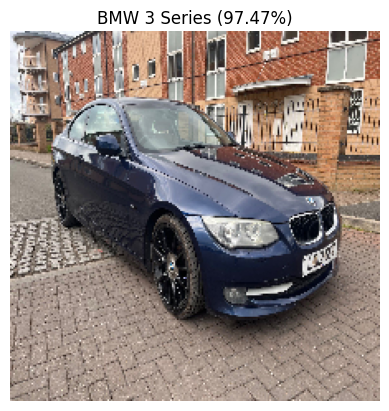

In [ ]:
from tensorflow.keras.preprocessing.image import load_img, img_to_array


input_image_file_path = "3ser.jpg"

# Load the input image and resize it to the target size (224, 224)
input_img = load_img(input_image_file_path, target_size=(224, 224))

# Convert the input image to a NumPy array and normalize the pixel values
input_img_array = img_to_array(input_img) / 255.0

# Add an extra dimension to match the model's input shape (1, 224, 224, 3) 3 is rgb, 1 is batch size
input_img_expanded = np.expand_dims(input_img_array, axis=0)

# Make a prediction using the preprocessed input image
prediction = model.predict(input_img_expanded)

# Convert the prediction into a class index/array, gives a number for highest prob class
predicted_class_index = np.argmax(prediction, axis=1)[0]

# Extract the confidence value (probability) for the predicted class
predicted_class_confidence = prediction[0][predicted_class_index] * 100

# Map the predicted class index back to the class name
predicted_class_name = class_names[predicted_class_index]

# Revert the normalization for displaying the image
input_img_array_display = input_img_array * 255.0

# Display the input image along with the predicted class name and confidence value
plt.imshow(input_img_array_display.astype(np.uint8))
plt.title(f"{predicted_class_name} ({predicted_class_confidence:.2f}%)")
plt.axis("off")
plt.show()


In [ ]:
#color